# Exercise 6: Clustering

In this assignment you will experiment with k-means as an image compression algorithm.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw6_123456789_987654321.ipynb` if you submitted in pairs and `hw6_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## Color image quantization

Color image quantization is the process of transforming an image so that it can be represented with a small subset of colors; a subset smaller than the image's original palette size. Image quantization is a form of lossy data compression since the number of bits used for the palette is reduced. During this compression some data is lost and therefore we must use a careful algorithm that will minimize the perceived difference between the original image and its quantized counterpart. Other than compression, image quantization plays an important role in image recognition algorithms.

When representing images in true color, each pixel is represented by 3 RGB components and each one of the 3 RGB components is represented by 8 bits and can take a value from 0 to 255. This means that in true color representation one can use 2^24≈16 Million different colors. In this exercise we will perform image quantization from images given in true color into 256, 16 or even less colors.

There are many algorithms for quantization. In this exercise, you are going to use K-means in color space to achieve quantization. The color (a point in RGB space) assigned to each pixel is the color of the centroid of the cluster. 

To summarize, every pixel in the image is a point in the three dimensional RGB space. We want to cluster these points into k clusters and then replace each pixel by the centroid of the cluster to which it was assigned to obtain the compressed image.

You might need to install skimage using `conda install -c conda-forge scikit-image`.

Also, note that `numpy.power()` is a slow function! https://stackoverflow.com/questions/25254541/why-is-numpy-power-60x-slower-than-in-lining

In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

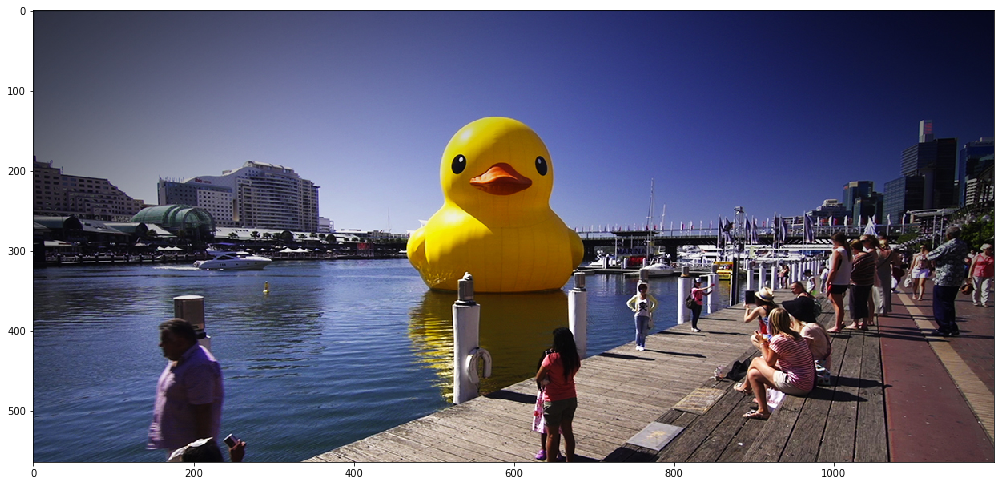

(564, 1200, 3)


In [2]:
# load the image and confirm skimage is imported properly.
image = io.imread('data/small_duck.jpg')
io.imshow(image)
io.show()
print(image.shape)

This single image has over 2 million values. Make sure your code is vectorized and efficient!

In [3]:
# save the dimensions of the image and reshape it for easier manipulation
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(image.shape[0]*image.shape[1],3)
print(image.shape)

(676800, 3)


### Note for preprocessing data:

Notice that all the colors and alpha scales have the same magnitude and range 0-255 therefore we dont need to normalize the data

## Random centroids (15 points)

Each centroid is a point in RGB space (color) in the image. This function should uniformly pick `k` centroids from the dataset.

Input: a single image of shape `(num_instances, 3)` and `k`, the number of centroids. Notice we are flattening the image to a two dimentional array.
Output: Randomly chosen centroids of shape `(k,3)`.

In [4]:
def get_random_centroids(X, k):
    return np.random.permutation(X)[:k]

In [5]:
k = 7 
centroids = get_random_centroids(image, k)

In [6]:
centroids

array([[ 28,  27,  43],
       [ 78,  53,  57],
       [ 91,  95, 130],
       [ 63,  70, 116],
       [162, 168, 190],
       [ 41,  59,  83],
       [ 67,  75,  86]], dtype=uint8)

## Distance function (25 points)

The Minkowski distance is a metric which can be considered as a generalization of the Euclidean and Manhattan distances. 

The Minkoski distance of order $p$ between two points: $\vec{x}=(x_1, ..., x_n)$ and $\vec{y}=(y_1, ..., y_n)$ is:
$$D(\vec{x},\vec{y}) = (\sum_{i=1}^n \mid x_i - y_i \mid ^p)^{\frac{1}{p}}$$

Implement the function `lp_distance` (=Minkoski distance).

Inputs: 
* a single image of shape `(num_instances, 3)` 
* the centroids `(k, 3)`
* the distance parameter p

output: array of shape `(k, num_instances)` thats holds the distances of all points in RGB space from all centroids

In [7]:
# to avoid using np.power, we inline low values of p
pow_funcs = [
    lambda x: 1,
    lambda x: np.abs(x, dtype="float"),
    # don't need to abs when we are squaring
    lambda x: x * x,
    lambda x: np.abs(x * x * x, dtype="float"),
    lambda x: x * x * x * x,
    lambda x: np.abs(x * x * x * x * x, dtype="float")
]

def optimized_pow(X, p):
    return pow_funcs[p](X) if p < len(pow_funcs) else X ** p

In [8]:
# same concept as before, avoid using np.power when possible for rooting
rt_funcs = [
    lambda x: x,
    lambda x: np.sqrt(x, dtype="float"),
    lambda x: np.cbrt(x, dtype="float")
]

def optimized_rt(X, p):
    return rt_funcs[p - 1](X) if p <= len(rt_funcs) else X ** (1.0 / p)

In [9]:
def lp_distance(X, centroids, p=2):
    return optimized_rt(optimized_pow(X[:,None, :] - centroids[None,:, :], p).sum(axis=X.ndim), p)

In [10]:
distances = lp_distance(image, centroids, 5)

In [11]:
distances

array([[3.32269903, 1.93318204, 2.83458979, ..., 2.60081459, 2.93556228,
        3.69310238],
       [3.04318323, 2.78319281, 3.03850498, ..., 2.35865582, 3.20467019,
        3.27889751],
       [3.64793006, 3.01708817, 3.39043641, ..., 3.22710881, 2.5555554 ,
        3.28750366],
       ...,
       [3.45033904, 2.89400454, 2.99005778, ..., 2.67512521, 3.23445157,
        3.44751205],
       [3.33572324, 3.35803776, 3.17570757, ..., 3.55649705, 2.        ,
        2.85895075],
       [3.31279513, 2.98503666, 3.04318323, ..., 3.63998984, 2.86193816,
        3.03379775]])

## Kmeans algorithm (40 points)

Calculate the locally optimal centroids as learned in class. At each iteration, assign every RGB point to the closest centroids and calculate new centroids by averaging the points that were assigned to every centroid. This function stops, 
when no improvement was made or once max_iter iterations passed.

A reasonable implementation runs on a Core i7 CPU in less than a minute with `k=16`.

In [12]:
def compute_classes(X, centroids, p):
    # creates an array where the index i represents which cluster instance i belongs to
    return np.argmin(lp_distance(X, centroids, p), axis=1)

In [13]:
def kmeans(X, k, p, max_iter=100, cluster_calc_func=np.mean):
    """
    Inputs:
    - X: a single image of shape (num_features, 3).
    - k: number of centroids.
    - p: the parameter governing the distance measure.
    - max_iter: the maximum number of iterations to perform.
    Outpust:
    - The calculated centroids
    - The final assignment of all RGB points to the closest centroids
    """
    centroids = get_random_centroids(X, k)
    classes = []
    for i in range(max_iter):
        classes = compute_classes(X, centroids, p)
        last_centroids = centroids
        # compute new centroids
        # note - cant vectorize this further, as each subarray is not the same shape
        centroids = np.array([cluster_calc_func(X[classes == i], axis=0) for i in range(k)])
        if np.array_equal(last_centroids, centroids):
            break
    # as the centroids got recomputed, then calculate final class assignments
    return centroids, compute_classes(X, centroids, p)

In [21]:
from timeit import default_timer as timer
start = timer()
centroids, classes = kmeans(image, k=16, p=1, max_iter=100, cluster_calc_func=np.median)
timer() - start

37.379702677999944

We obtained the locally optimal centroids (colors) from our image. To reconstruct the compressed image, we need to specify the color for each pixel that our algorithm associated with some centroid. The following cell does that for you.

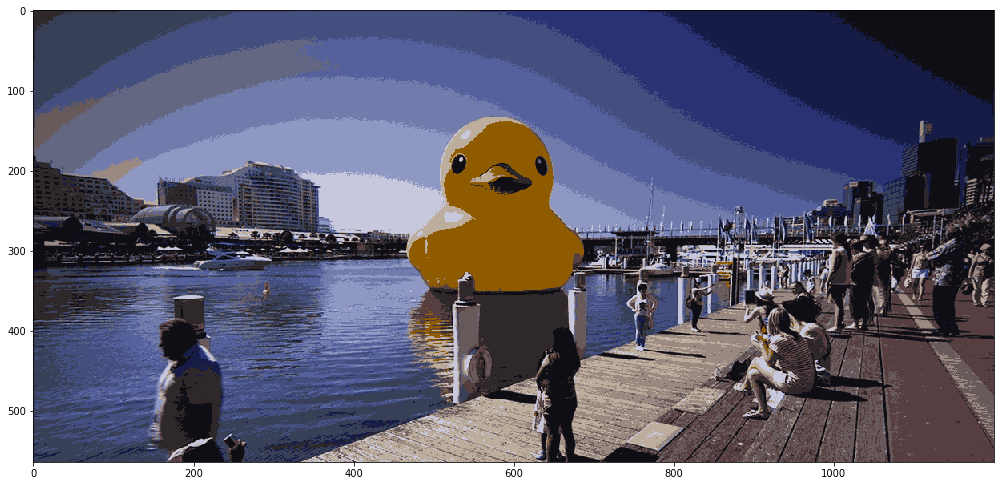

In [22]:
image_classes = classes.reshape(rows,cols) 
compressed_image = np.zeros((image_classes.shape[0],image_classes.shape[1],3),dtype=np.uint8 )
for i in range(image_classes.shape[0]):
    for j in range(image_classes.shape[1]):
            compressed_image[i,j,:] = centroids[image_classes[i,j],:]
io.imshow(compressed_image)
io.show()

## Hyper parameter tuning (20 points)

Run the algorithm for each of the following values for `p = [1,2,3,4,5]` . Test multiple values for `k=[4,8,16]` using two different cluster calculation criteria: the mean and the median of the cluser. For each test, calculate the intertia and visualize it using graphs. Explain your results.

In [23]:
def inertia(X, centroids, classes):
    dist = X - centroids[classes]
    
    # Normalize value so its bit within a better order of magnitude
    return np.sqrt(np.sum(dist * dist, dtype="float")) / X.shape[0]

In [24]:
inertia(image, centroids, classes)

0.028943696139443975

In [25]:
import itertools

In [26]:
p_values = [1,2,3,4,5]
k_values = [4,8,16]
calc_values = [np.mean, np.median]

results = {}

for parameters in itertools.product(p_values, k_values, calc_values):
    run_centroids, run_classes = kmeans(image, p=parameters[0], k=parameters[1], cluster_calc_func=parameters[2])
    results[parameters] = inertia(image, run_centroids, run_classes)

In [27]:
for parameters in results.keys():
    #print(parameters)
    print(f"p = {parameters[0]}, k = {parameters[1]}, func = {parameters[2].__name__}" )
    print(f"inertia: {results[parameters]}")
    print("===========================================")

p = 1, k = 4, func = mean
inertia: 0.05419930159108944
p = 1, k = 4, func = median
inertia: 0.0589227929409097
p = 1, k = 8, func = mean
inertia: 0.03894523999049537
p = 1, k = 8, func = median
inertia: 0.04262178710864508
p = 1, k = 16, func = mean
inertia: 0.026019361410581653
p = 1, k = 16, func = median
inertia: 0.03441816997185584
p = 2, k = 4, func = mean
inertia: 0.05401887410976562
p = 2, k = 4, func = median
inertia: 0.05645784128141426
p = 2, k = 8, func = mean
inertia: 0.0379392344559522
p = 2, k = 8, func = median
inertia: 0.040816448467023196
p = 2, k = 16, func = mean
inertia: 0.027444718952837323
p = 2, k = 16, func = median
inertia: 0.02827346533249795
p = 3, k = 4, func = mean
inertia: 0.054112126296639515
p = 3, k = 4, func = median
inertia: 0.05547515549617634
p = 3, k = 8, func = mean
inertia: 0.03809637701533815
p = 3, k = 8, func = median
inertia: 0.0409161220166762
p = 3, k = 16, func = mean
inertia: 0.025507566149660852
p = 3, k = 16, func = median
inertia: 0.02

<ipython-input-28-9724a7d2fefe>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(p_values, [data[(p, k, func)] for p in p_values], "-ok", color=colors[k], label=f"{k} clusters")


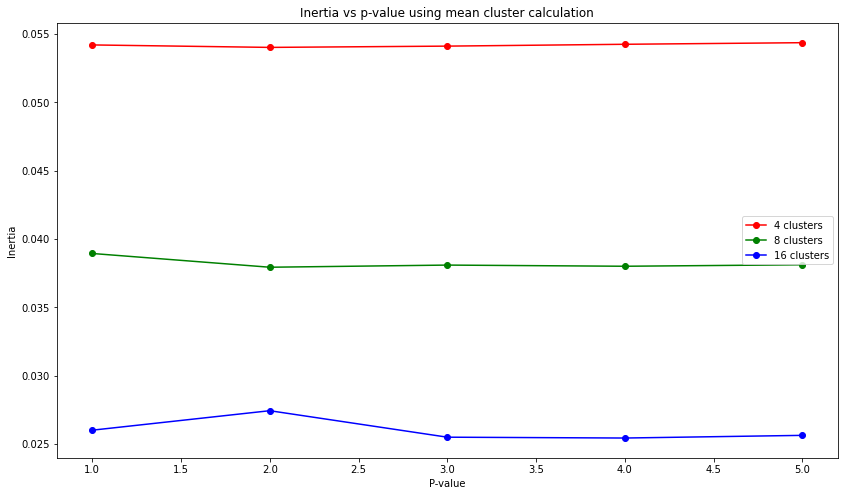

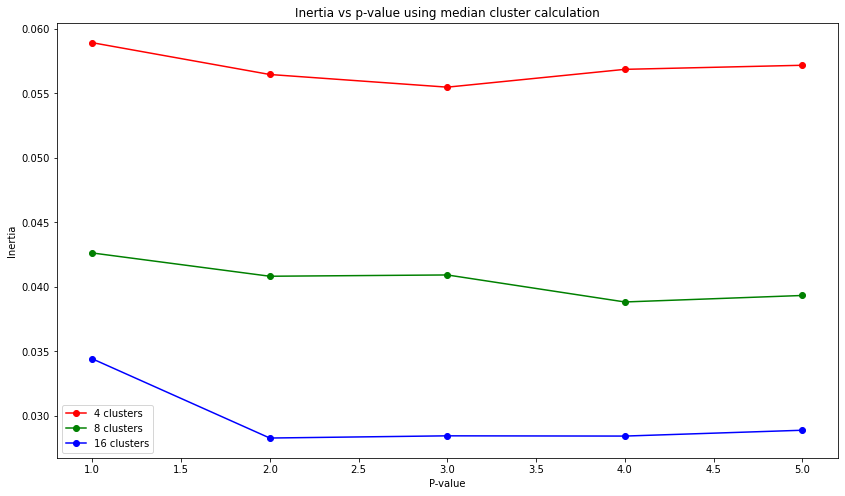

In [28]:
colors = {
    4: "red",
    8: "green",
    16: "blue"
}

def show_visualization(data, func, name):
    for k in k_values:
        plt.plot(p_values, [data[(p, k, func)] for p in p_values], "-ok", color=colors[k], label=f"{k} clusters")
    plt.xlabel('P-value')
    plt.ylabel('Inertia')
    plt.legend()
    plt.title(name)
    plt.show()

show_visualization(results, np.mean, "Inertia vs p-value using mean cluster calculation")
show_visualization(results, np.median, "Inertia vs p-value using median cluster calculation")

From the results, it seems that mean cluster calculation criteria overall performs better than median. This makes sense, as when we use the median, we could be affected by a lot of outliers and the cluster will be off.

It also seems that the more clusters we add, the better the inertia value, as there are more specialized clusters for different groups of pixels so less are left out of a good one.

The p-value doesn't have much of an imapct when using mean clustering criteria, but in median clustering it is important to use p >= 2.